In [0]:
sc.version

u'2.4.4'

In [0]:
#lets import some useful libraries
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import math


In [0]:
print(type(sc))

<class 'pyspark.context.SparkContext'>


In [0]:
#define the filenames
Training_filename ='s3://netflixfinal/TrainingRatings.txt'
Testing_filename = 's3://netflixfinal/TestingRatings.txt'
Movie_filename = 's3://netflixfinal/movie_titles.txt'

In [0]:
#build schema
from pyspark.sql.types import *

movies_df_schema = StructType(
  [StructField('mID', IntegerType()),
   StructField('yearofrelease', IntegerType()),
   StructField('title', StringType())]
)
Training_df_schema = StructType(
  [StructField('mID', IntegerType()),
   StructField('uID', IntegerType()),
   StructField('ratings',DoubleType())]
)

Testing_df_schema = StructType(
  [StructField('mID', IntegerType()),
   StructField('uID', IntegerType()),
   StructField('ratings',DoubleType())]
)

In [0]:
input_file = "s3://netflixfinal/TrainingRatings.txt"
logData = sc.textFile(input_file)

In [0]:
logData.count() 

3255352

In [0]:
logData.take(5)

[u'8,1744889,1.0',
 u'8,1395430,2.0',
 u'8,1205593,4.0',
 u'8,1488844,4.0',
 u'8,1447354,1.0']

In [0]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *

raw_training_df = sqlContext.read.format('txt').options(inferSchema=True).schema(Training_df_schema).csv(Training_filename)
training_df = raw_training_df

raw_testing_df = sqlContext.read.format('txt').options(inferSchema=True).schema(Testing_df_schema).csv(Testing_filename)
testing_df = raw_testing_df
raw_movies_df = sqlContext.read.format('txt').options(inferSchema=True).schema(movies_df_schema).csv(Movie_filename)
movies_df = raw_movies_df

training_df.cache()
testing_df.cache()
movies_df.cache()

assert training_df.is_cached
assert testing_df.is_cached
assert movies_df.is_cached

raw_training_count = raw_training_df.count()
training_count = training_df.count()
raw_testing_count = raw_testing_df.count()
testing_count = testing_df.count()
raw_movies_count = raw_movies_df.count()
movies_count = movies_df.count()

print 'There are %s training, %s testing and %s movies in the datasets' % (training_count,testing_count, movies_count)
print 'Training:'
training_df.show(3)
print 'Testing:'
testing_df.show(3)
print 'Movies:'
movies_df.show(3, truncate=False)

assert raw_training_count == training_count
assert raw_testing_count == testing_count
assert raw_movies_count == movies_count

There are 3255352 training, 100478 testing and 17770 movies in the datasets
Training:
+---+-------+-------+
|mID|    uID|ratings|
+---+-------+-------+
|  8|1744889|    1.0|
|  8|1395430|    2.0|
|  8|1205593|    4.0|
+---+-------+-------+
only showing top 3 rows

Testing:
+---+-------+-------+
|mID|    uID|ratings|
+---+-------+-------+
|  8| 573364|    1.0|
|  8|2149668|    3.0|
|  8|1089184|    3.0|
+---+-------+-------+
only showing top 3 rows

Movies:
+---+-------------+--------------------------+
|mID|yearofrelease|title                     |
+---+-------------+--------------------------+
|1  |2003         |Dinosaur Planet           |
|2  |2004         |Isle of Man TT 2004 Review|
|3  |1997         |Character                 |
+---+-------------+--------------------------+
only showing top 3 rows



# New Section

In [0]:
#finding out the distinct movies in the training set
training_df.select('mID').distinct().count()

1821

In [0]:
#finding out the distinct users in the training set
training_df.select('uID').distinct().count()

28978

In [0]:
#finding out the distinct movies in the testing set
testing_df.select('mID').distinct().count()

1701

In [0]:
testing_df.select('uID').distinct().count()

27555

In [0]:
#lets convert to a Pandas Dataframe 

trainingPandas = training_df.toPandas()
testingPandas = testing_df.toPandas()

In [0]:
trainingPandas.head()

,mID,uID,ratings
0,8,1744889,1.0
1,8,1395430,2.0
2,8,1205593,4.0
3,8,1488844,4.0
4,8,1447354,1.0


In [0]:
testingPandas.head()

,mID,uID,ratings
0,8,573364,1.0
1,8,2149668,3.0
2,8,1089184,3.0
3,8,2465894,3.0
4,8,534508,1.0


In [0]:
len(trainingPandas)

3255352

In [0]:
len(testingPandas)

100478

lets find the overall rates for movies and users in both set

In [0]:
#checking overall average rate of the movies with their counts  in the training set
movies_ratings_average = pd.DataFrame(trainingPandas.groupby('mID')['ratings'].mean())
movies_ratings_average['counts'] =pd.DataFrame(trainingPandas.groupby('mID')['ratings'].count())
movies_ratings_average.tail()

,ratings,counts
mID,,
17725,3.431353,2003
17728,2.691176,68
17734,2.926829,41
17741,3.205882,1020
17742,2.768293,246


In [0]:
#checking overall average rate of the user with their counts  in the training set
user_ratings_average = pd.DataFrame(trainingPandas.groupby('uID')['ratings'].mean())
user_ratings_average['counts'] =pd.DataFrame(trainingPandas.groupby('uID')['ratings'].count())
user_ratings_average.tail()

,ratings,counts
uID,,
2648869,3.625000,112
2648885,3.948529,136
2649120,3.772152,79
2649267,3.851852,81
2649285,2.980769,104


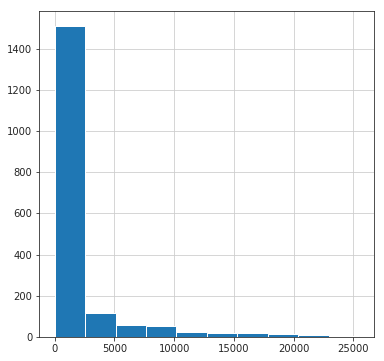

In [0]:
# lets see this graphed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

plt.figure(figsize=(6,6))
movies_ratings_average['counts'].hist(bins=10)

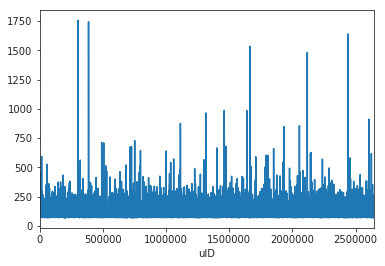

In [0]:
#showing how many movies each user is watching
trainingPandas.groupby('uID')['mID'].count().plot()

In [0]:
#checking overall average rate of the movies with their counts  in the training set
movies_ratings_averageTest = pd.DataFrame(testingPandas.groupby('mID')['ratings'].mean())
movies_ratings_averageTest['counts'] =pd.DataFrame(testingPandas.groupby('mID')['ratings'].count())
movies_ratings_averageTest.tail()

,ratings,counts
mID,,
17725,3.211538,52
17728,4.500000,2
17734,3.000000,1
17741,2.968750,32
17742,3.125000,8


In [0]:
#checking overall average rate of the user with their counts  in the training set
user_ratings_averageTest = pd.DataFrame(testingPandas.groupby('uID')['ratings'].mean())
user_ratings_averageTest['counts'] =pd.DataFrame(testingPandas.groupby('uID')['ratings'].count())
user_ratings_averageTest.tail()

,ratings,counts
uID,,
2648869,2.777778,9
2648885,4.000000,5
2649120,5.000000,2
2649267,4.142857,7
2649285,2.333333,3


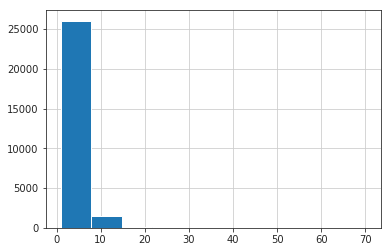

In [0]:
# lets visualize each users rating count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

user_ratings_averageTest['counts'].hist(bins=10)

In [0]:
testingPandas.groupby('uID')['ratings'].count().sort_values(ascending=False).head()

uID
1664010    70
2439493    52
305344     52
387418     51
1314869    38
Name: ratings, dtype: int64

In [0]:
testingPandas.groupby('mID')['ratings'].count().sort_values(ascending=False).head()

mID
6971    811
4640    756
6287    737
9728    706
8915    695
Name: ratings, dtype: int64

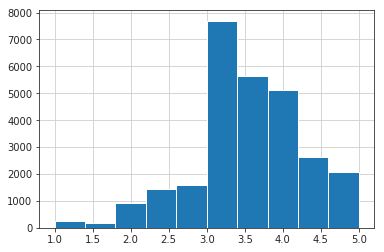

In [0]:
user_ratings_averageTest['ratings'].hist(bins=10)

# Problem 1


Now that the preprocessing is over and we have viewed the way our data is displaced lets start by building a collaborative filtering using ALS.

Because we would still like to know the best parameters for the ALS model, we will be alternating mainly the rank and the maxiter parameters. We will split our training further to help us iron out these best paramaters

we will be using the coldstrategy to drop nans

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
training,testing= training_df.randomSplit([0.8, 0.2])

als = ALS(maxIter=5, regParam=0.01, userCol="uID", itemCol="mID", ratingCol="ratings",coldStartStrategy="drop")
model = als.fit(training)


In [0]:
predictions = model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratings",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.864900801896


In [0]:
ranks = [6,8,10, 12]
for i in range(len(ranks)):
    print(i)
    als = ALS(maxIter=10,rank=ranks[i], regParam=0.01, userCol="uID", itemCol="mID", ratingCol="ratings",coldStartStrategy="drop")
    model = als.fit(training)
    predictions = model.transform(testing)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratings",predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print("Root-mean-square error = " + str(rmse))
    predictions.show()

0
Root-mean-square error = 0.853788055054
+----+-------+-------+----------+
| mID|    uID|ratings|prediction|
+----+-------+-------+----------+
|2366| 799672|    4.0| 3.6280363|
|2366|1704384|    3.0| 2.9121733|
|2366|1172778|    4.0|  2.931837|
|2366|1312530|    2.0| 2.5952897|
|2366|1684416|    1.0| 1.9430808|
|2366|2360117|    3.0| 3.2673805|
|2366| 461110|    2.0|  2.693872|
|2366| 477387|    1.0| 1.4798545|
|2366|1256465|    3.0|  2.584482|
|2366| 555528|    4.0| 2.7539434|
|2366|2171824|    2.0| 2.6815217|
|2366| 862850|    2.0| 2.6110482|
|2366|1993440|    3.0| 2.7914984|
|2366|2086206|    5.0| 3.5532084|
|2366|1258349|    3.0| 2.6675565|
|2366|1723385|    3.0|  3.054803|
|2366|1324830|    4.0|  3.382517|
|2366| 225674|    5.0| 3.5278742|
|2366|2269039|    3.0| 3.4574835|
|2366|2473973|    4.0|   3.27963|
+----+-------+-------+----------+
only showing top 20 rows

1
Root-mean-square error = 0.852914537865
+----+-------+-------+----------+
| mID|    uID|ratings|prediction|
+----+

For our models built, the paramaters rank of 8 and maxiter of 10 seemed to have yieled our best model. Lets variy the regparams for this same model and see if that decreases our root mean square error

In [0]:
als = ALS(maxIter=10,rank=8, regParam=0.09, userCol="uID", itemCol="mID", ratingCol="ratings",coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratings",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
predictions.show()

Root-mean-square error = 0.8491849282
+----+-------+-------+----------+
| mID|    uID|ratings|prediction|
+----+-------+-------+----------+
|2366| 799672|    4.0| 3.3448634|
|2366|1704384|    3.0|  2.838464|
|2366|1172778|    4.0| 2.8995314|
|2366|1312530|    2.0| 2.5765352|
|2366|1684416|    1.0| 2.1967905|
|2366|2360117|    3.0|  3.163447|
|2366| 461110|    2.0| 2.6697888|
|2366| 477387|    1.0| 1.5132037|
|2366|1256465|    3.0|  2.731005|
|2366| 555528|    4.0| 2.7608988|
|2366|2171824|    2.0| 2.6274722|
|2366| 862850|    2.0| 2.5755546|
|2366|1993440|    3.0| 2.6887681|
|2366|2086206|    5.0| 3.5817184|
|2366|1258349|    3.0| 2.7180274|
|2366|1723385|    3.0| 3.0862525|
|2366|1324830|    4.0| 3.3419712|
|2366| 225674|    5.0| 3.6483169|
|2366|2269039|    3.0| 3.3670404|
|2366|2473973|    4.0| 3.2832742|
+----+-------+-------+----------+
only showing top 20 rows



Well that seems to be our best model yet. Now that we have evaluated the ALS model lets look some other models. But before that lets see how similar the users and movies are.

# Problem 2

We will analyze our data and find the average rating of movie given all users who rated the movie- average overlap of users for items
 
We will also find the average rating given by users - average of items for users

In [0]:
def get_average(user):
    summed =0
    count =0

    for i in range(len(user)):
        if(user[i]==0):
            summed = summed +0
        else:
            summed= user[i] +summed
            count= 1+ count
    avgg=summed/count
    return avgg

In [0]:
#first lets find the unique users and movies in our dataframe
len(testingPandas['uID'].unique())

27555

In [0]:
len(testingPandas['mID'].unique())

1701

In [0]:
#now lets create a new dataframe with userID as index and the movieId as columns for our training data
user_movie_rating = trainingPandas.pivot_table(index='uID', columns='mID', values='ratings')
user_movie_rating.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will use the first five movies and users with the most count from our test data.
Movies with IDs:6971,4640,6287,9728,8915
Users with the IDs:1664010,2439493,305344,387418,1314869

In [0]:
#lets see if the first Movie Id exist in our training dataframe

In [0]:
user_movie_rating[6971]

uID
7          4.0
79         5.0
199        4.0
481        4.0
769        4.0
906        3.0
1310       5.0
1333       4.0
1427       4.0
1442       5.0
1457       5.0
1500       4.0
1527       4.0
1918       5.0
2000       5.0
2128       5.0
2213       5.0
2225       5.0
2307       4.0
2455       NaN
2469       NaN
2678       5.0
2787       5.0
2905       3.0
2976       NaN
3039       3.0
3321       4.0
3363       5.0
3458       NaN
3595       5.0
          ... 
2646634    5.0
2646703    5.0
2646712    5.0
2646766    5.0
2647162    5.0
2647197    4.0
2647396    4.0
2647406    4.0
2647559    5.0
2647648    3.0
2647871    4.0
2647888    5.0
2648085    5.0
2648176    NaN
2648181    NaN
2648212    4.0
2648287    4.0
2648351    3.0
2648465    3.0
2648502    4.0
2648572    4.0
2648589    4.0
2648730    4.0
2648734    5.0
2648853    2.0
2648869    4.0
2648885    5.0
2649120    5.0
2649267    3.0
2649285    5.0
Name: 6971, Length: 28978, dtype: float64

In [0]:
#lets fill the nan values with 0
user_movie_rating.fillna(0, inplace= True)
user_movie_rating.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
user_movie_rating[8915]

uID
7          0.0
79         0.0
199        4.0
481        0.0
769        3.0
906        0.0
1310       4.0
1333       4.0
1427       0.0
1442       5.0
1457       3.0
1500       3.0
1527       0.0
1918       3.0
2000       3.0
2128       0.0
2213       5.0
2225       4.0
2307       4.0
2455       5.0
2469       3.0
2678       4.0
2787       4.0
2905       1.0
2976       4.0
3039       3.0
3321       4.0
3363       5.0
3458       2.0
3595       5.0
          ... 
2646634    0.0
2646703    5.0
2646712    4.0
2646766    5.0
2647162    0.0
2647197    5.0
2647396    0.0
2647406    0.0
2647559    0.0
2647648    3.0
2647871    3.0
2647888    5.0
2648085    0.0
2648176    5.0
2648181    0.0
2648212    3.0
2648287    4.0
2648351    0.0
2648465    0.0
2648502    5.0
2648572    4.0
2648589    4.0
2648730    5.0
2648734    4.0
2648853    4.0
2648869    4.0
2648885    4.0
2649120    4.0
2649267    0.0
2649285    3.0
Name: 8915, Length: 28978, dtype: float64

In [0]:
user1664010= list(user_movie_rating.loc[1664010])
avg1664010= get_average(user1664010)
print(avg1664010)

4.23843648208


In [0]:
user2439493= list(user_movie_rating.loc[2439493])
avg2439493= get_average(user2439493)
print(avg2439493)

1.2256097561


In [0]:
user305344= list(user_movie_rating.loc[305344])
avg305344= get_average(user305344)
print(avg305344)

1.90438247012


In [0]:
user387418= list(user_movie_rating.loc[387418])
avg387418= get_average(user387418)
print(avg387418)

1.84059633028


In [0]:
user1314869= list(user_movie_rating.loc[1314869])
avg1314869= get_average(user1314869)
print(avg1314869)

2.97098445596


In [0]:
Est_over_item_user =avg1314869+avg387418+avg305344+avg2439493+avg1664010
print(Est_over_item_user/5)

2.43600189891


The Est_item_user gives the overlap of item rated by  our 5 selected users

In [0]:
#now lets create a new dataframe with userID as index and the movieId as columns for our training data
movie_user_rating = trainingPandas.pivot_table(index='mID', columns='uID', values='ratings')
movie_user_rating.head()

uID,7,79,199,481,769,906,1310,1333,1427,1442,...,2648572,2648589,2648730,2648734,2648853,2648869,2648885,2649120,2649267,2649285
mID,,,,,,,,,,,,,,,,,,,,,
8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,4.0,NaN,NaN,NaN,NaN,3.0,3.0,2.0,NaN,4.0,...,NaN,3.0,4.0,NaN,2.0,NaN,4.0,NaN,NaN,4.0
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
movie_user_rating.fillna(0, inplace= True)
movie_user_rating.head()

uID,7,79,199,481,769,906,1310,1333,1427,1442,...,2648572,2648589,2648730,2648734,2648853,2648869,2648885,2649120,2649267,2649285
mID,,,,,,,,,,,,,,,,,,,,,
8,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,4.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,4.0,...,0.0,3.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,4.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
movie6971= list(movie_user_rating.loc[6971])
avg6971= get_average(movie6971)
print(avg6971)

4.07181561175


In [0]:
movie4640= list(movie_user_rating.loc[4640])
avg4640= get_average(movie4640)
print(avg4640)

4.04743889479


In [0]:
movie6287= list(movie_user_rating.loc[6287])
avg6287= get_average(movie6287)
print(avg6287)

3.72610994958


In [0]:
movie9728= list(movie_user_rating.loc[9728])
avg9728= get_average(movie9728)
print(avg6971)

4.07181561175


In [0]:
movie8915= list(movie_user_rating.loc[8915])
avg8915= get_average(movie8915)
print(avg8915)

3.96633730505


In [0]:
Est_over_user_item =avg8915+avg6971+avg6287+avg4640+avg6971
print(Est_over_user_item/5)

3.97670347458


The Est_over_user_item gives the overlap of users that rated items rated by  our 5 selected users

# My Take on the Averages


As expected the overlap of users that rated items is higher than the overlap of items rated by users. This is because, more often than not a users rate on an item is influenced mostly by personal preference. ie, a user that likes the cartoons is likely to rate the movie Tom and Jerry relatively high. Likewise in the inverse, a user that hates cartoons is likely to rate the cartoon with a lower rate. the average overall for both is these users is like to be fairly even, However, the overlap of items rated by users will have a combination of very high and very low rates and this is likely to result in an overall high average

# Part 2 section B --The Selection

	I selected the Matrix factorization approach using SVD simply because of its ability to scale across the large data. 
	The similarity measure- the user-user or item-item matrix for our dataset with more than 1000 distinct users would require a lot of computation and memory. This approach considering the size of our data would not be the best option.


I will be normalizing my dataset because, not only does our testing data contains several nans as a result of not being rated, but also, every time a new user is entered, without any prior rated information, without normalizing the model most likely cannot predict any movie to this new user.

	Finally, my SVD approach is because this approach allows for the dataset to be scaled and appropriately reduces the large dimensions to a smaller set that is easily scalable through

In [0]:
#Now lets create a normalized dataframe from our training set
normalised_mat =  user_movie_rating - np.asarray([(np.mean(user_movie_rating, 1))]).T
normalised_mat.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,4.777046,3.777046,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,...,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954
79,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,...,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490
199,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,3.846238,...,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762
481,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,4.823174,...,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826
769,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,...,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884


# Problem 3: The SVD Approach

In [0]:
from sklearn.model_selection import train_test_split
#lets split the training further and use this as a test set

trainPandas, testPandas = train_test_split(trainingPandas, test_size=0.6, random_state=0)

In [0]:
trainPandas.head()

,mID,uID,ratings
1177823,6066,1807643,1.0
2607747,14144,1859991,3.0
2982630,16082,522637,1.0
1016119,5069,66187,4.0
1715563,9481,920098,3.0


In [0]:
#lets pivot our split data
train = trainPandas.pivot_table(index='uID', columns='mID', values='ratings')
train.fillna(0, inplace= True)
train.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#lets pivot our split data
test = testPandas.pivot_table(index='uID', columns='mID', values='ratings')
test.fillna(0, inplace= True)
test.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds


In [0]:
trained = train.as_matrix()
user_ratings_mean = np.mean(trained, axis = 1)
trained_demeaned = trained - user_ratings_mean.reshape(-1, 1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
U, sigma, Vt = svds(trained_demeaned, k = 50)

In [0]:
sigma = np.diag(sigma)

In [0]:
all_user_predicted_ratgs = np.dot(np.dot(U, sigma), Vt) +user_ratings_mean.reshape(-1, 1)

In [0]:
print(user_ratings_mean)

[0.08241758 0.05879121 0.06428571 ... 0.05274725 0.04505495 0.07197802]


In [0]:
print((all_user_predicted_ratgs[0]))

[ 0.0341765   0.74924155 -0.00162638 ... -0.00334478 -0.0166587
 -0.00939068]


In [0]:
preds_df = pd.DataFrame(all_user_predicted_ratgs, columns = train.columns, index= train.index)
preds_df.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,0.034177,0.749242,-0.001626,-0.018925,-0.002373,-0.007050,-0.003369,-0.003599,-0.000042,0.412604,...,0.259888,-0.004119,-0.001759,0.147066,-0.019570,0.051315,-0.001293,-0.003345,-0.016659,-0.009391
79,0.004857,0.812900,0.016973,0.071726,0.013448,0.012980,0.014458,0.015650,0.008345,0.334227,...,0.178450,0.013557,0.009924,0.112814,0.016820,-0.041928,0.008691,0.009435,-0.007656,0.014185
199,0.196017,-0.662838,-0.008799,0.016020,-0.008925,-0.005025,-0.006814,0.001732,-0.001292,0.416214,...,0.008295,-0.014459,-0.006628,-0.041134,-0.004697,0.160741,-0.007396,-0.005472,0.063112,-0.028048
481,0.060348,1.181981,-0.002816,0.046674,-0.000397,-0.001576,-0.006943,0.004081,-0.011065,0.835635,...,0.224740,-0.004276,-0.003616,0.166618,0.002012,-0.021220,-0.004803,-0.007340,0.087379,0.004079
769,0.142250,0.348481,0.006319,0.077472,0.011265,0.008808,0.003678,0.007945,-0.005922,0.117017,...,0.002384,0.008751,0.010659,-0.025700,0.021211,0.139224,0.007100,0.005796,0.028668,0.003243


In [0]:
preds_df.loc[7]

mID
8        0.034177
28       0.749242
43      -0.001626
48      -0.018925
61      -0.002373
64      -0.007050
66      -0.003369
92      -0.003599
96      -0.000042
111      0.412604
122     -0.016417
123     -0.007917
127      0.114384
140     -0.002458
145      0.006462
154     -0.001193
156      0.374257
174      0.003980
185      0.101745
192     -0.006233
207     -0.004445
214     -0.003109
218     -0.007071
222      0.001744
229      0.008892
237      0.009489
259      0.002659
267      0.031785
276     -0.002361
287      0.006761
           ...   
17466   -0.001497
17515   -0.003800
17522    0.076740
17523    0.007044
17534   -0.007045
17536    0.076258
17551    0.002016
17554    0.034623
17556    0.020014
17558   -0.023650
17561    0.057682
17574    0.713150
17616    0.000613
17624    0.211436
17626   -0.006226
17635    0.019034
17640   -0.003030
17642   -0.027737
17650    0.068042
17653    0.032951
17654    0.259888
17660   -0.004119
17689   -0.001759
17693    0.147066
17706 

In [0]:
moviesPandas = movies_df.toPandas()
moviesPandas.head()

,mID,yearofrelease,title
0,1.0,2003.0,Dinosaur Planet
1,2.0,2004.0,Isle of Man TT 2004 Review
2,3.0,1997.0,Character
3,4.0,1994.0,Paula Abdul's Get Up & Dance
4,5.0,2004.0,The Rise and Fall of ECW


In [0]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.loc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.uID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'mID', right_on = 'mID').
                     sort_values(['ratings'], ascending=False)
                 )

    print 'User {0} has already rated {1} movies.'.format(userID, user_full.shape[0])
    print 'Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations)
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['mID'].isin(user_full['mID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'mID',
               right_on = 'mID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations


In [0]:
already_rated, predictions = recommend_movies(preds_df, 738747, moviesPandas, trainPandas, 10)

User 738747 has already rated 50 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [0]:
already_rated.head(10)

,mID,uID,ratings,yearofrelease,title
10,6971,738747,5.0,1986.0,Ferris Bueller's Day Off
37,3084,738747,5.0,1975.0,Rollerball
4,10662,738747,5.0,1988.0,Akira
42,12293,738747,5.0,1972.0,The Godfather
41,8915,738747,5.0,1991.0,Terminator 2: Extreme Edition
39,16147,738747,5.0,1999.0,The Sopranos: Season 1
23,13636,738747,4.0,1982.0,Fast Times at Ridgemont High
24,3151,738747,4.0,2004.0,Napoleon Dynamite
26,14209,738747,4.0,2000.0,Pitch Black
27,13298,738747,4.0,1985.0,National Lampoon's European Vacation


In [0]:
predictions

,mID,yearofrelease,title
5745,5760.0,2001.0,The Sopranos: Season 3
9456,9481.0,1972.0,Deliverance
14667,14712.0,2001.0,Tomb Raider
5712,5727.0,1984.0,The Last Starfighter
3625,3638.0,2003.0,Bad Boys II
8827,8851.0,1998.0,Rounders
4748,4761.0,1981.0,The Cannonball Run
7125,7145.0,1984.0,Star Trek III: The Search for Spock
11806,11837.0,1987.0,Three Men and a Baby
11582,11613.0,1974.0,The Man with the Golden Gun


In [0]:
#the absolute mean squared error for our taining set
math.sqrt(mean_squared_error(all_user_predicted_ratgs,trained_demeaned))

0.44889265941023837

In [0]:
#now that the model is trained lets try predicting first for our smaller test set
tested = test.as_matrix()
usertested_ratings_mean = np.mean(tested, axis = 1)
tested_demeaned = tested - usertested_ratings_mean.reshape(-1, 1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
U, sigma, Vt = svds(tested_demeaned, k = 50)

In [0]:
sigma = np.diag(sigma)

In [0]:
all_user_predicted_ratgs = np.dot(np.dot(U, sigma), Vt) +usertested_ratings_mean.reshape(-1, 1)

In [0]:
#that didnt seem bad enough
math.sqrt(mean_squared_error(all_user_predicted_ratgs,tested_demeaned))

0.5307017722376987

In [0]:
#Now lests predict for our actual testing set
#now lets create a new dataframe with userID as index and the movieId as columns for our testing data
userTst_movie_rating = testingPandas.pivot_table(index='uID', columns='mID', values='ratings')
userTst_movie_rating.fillna(0, inplace= True)
userTst_movie_rating.head()



mID,8,28,43,48,61,64,66,92,96,111,...,17653,17654,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
finaltested = userTst_movie_rating.as_matrix()
fusertested_ratings_mean = np.mean(finaltested, axis = 1)
ftested_demeaned = finaltested - fusertested_ratings_mean.reshape(-1, 1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
U, sigma, Vt = svds(ftested_demeaned, k = 50)
sigma = np.diag(sigma)
final_all_user_predicted_ratgs = np.dot(np.dot(U, sigma), Vt) +fusertested_ratings_mean.reshape(-1, 1)

lets evaluate the approach for our overall testing data

In [0]:
#Using our Mean squared error
math.sqrt(mean_squared_error(final_all_user_predicted_ratgs,ftested_demeaned))

0.13843667198102874

In [0]:
#using our absolute error approach
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ftested_demeaned,final_all_user_predicted_ratgs)

0.01903863396844195

Our model seems to be performing  very well. Lets go ahead and add me as a new user

In [0]:
#adding myself as a user.
#I will assume the id of 0000
me = {'uID':0,'mID': 8, 'ratings': 5.0}
me1 = {'uID':0,'mID': 61, 'ratings': 4.0}
me2 = {'uID':0,'mID': 66, 'ratings': 3.0}
me3 = {'uID':0,'mID': 96, 'ratings': 2.0}
me4 = {'uID':0,'mID': 111, 'ratings': 5.0}
me5 = {'uID':0,'mID': 17734}
me6 = {'uID':0,'mID': 17742}

In [0]:

testingPandas2=testingPandas.append(me, ignore_index=True )
testingPandas2=testingPandas2.append(me1, ignore_index=True )
testingPandas2=testingPandas2.append(me2, ignore_index=True )
testingPandas2=testingPandas2.append(me3, ignore_index=True )
testingPandas2=testingPandas2.append(me4, ignore_index=True )
testingPandas2=testingPandas2.append(me5, ignore_index=True )
testingPandas2=testingPandas2.append(me6, ignore_index=True )

In [0]:
testingPandas2['uID']==0

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
100455    False
100456    False
100457    False
100458    False
100459    False
100460    False
100461    False
100462    False
100463    False
100464    False
100465    False
100466    False
100467    False
100468    False
100469    False
100470    False
100471    False
100472    False
100473    False
100474    False
100475    False
100476    False
100477    False
100478     True
100479     True
100480     True
100481     True
100482     True
100483     True
100484     True
Name: uID, Length: 10048

In [0]:
testingPandas2.pivot_table(index='uID', columns='mID', values='ratings')

mID,8.0,28.0,43.0,48.0,61.0,64.0,66.0,92.0,96.0,111.0,...,17653.0,17654.0,17689.0,17693.0,17706.0,17725.0,17728.0,17734.0,17741.0,17742.0
uID,,,,,,,,,,,,,,,,,,,,,
0.0,5.0,NaN,NaN,NaN,4.0,NaN,3.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Now lests predict for our new testing set
# as columns for our testing data
userTst_movie_rating2 = testingPandas2.pivot_table(index='uID', columns='mID', values='ratings')
userTst_movie_rating2.fillna(0, inplace= True)
userTst_movie_rating2.head()


mID,8.0,28.0,43.0,48.0,61.0,64.0,66.0,92.0,96.0,111.0,...,17653.0,17654.0,17689.0,17693.0,17706.0,17725.0,17728.0,17734.0,17741.0,17742.0
uID,,,,,,,,,,,,,,,,,,,,,
0.0,5.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
finaltested2 = userTst_movie_rating2.as_matrix()
fusertested_ratings_mean2 = np.mean(finaltested2, axis = 1)
ftested_demeaned2 = finaltested2 - fusertested_ratings_mean2.reshape(-1, 1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
U, sigma, Vt = svds(ftested_demeaned2, k = 50)
sigma = np.diag(sigma)
final_all_user_predicted_ratgs2 = np.dot(np.dot(U, sigma), Vt) +fusertested_ratings_mean2.reshape(-1, 1)

In [0]:
print(fusertested_ratings_mean2)

[0.0111699  0.00587889 0.00940623 ... 0.00587889 0.01704879 0.00411523]


In [0]:
Final_preds_df = pd.DataFrame(final_all_user_predicted_ratgs2, columns = userTst_movie_rating2.columns, index= userTst_movie_rating2.index)
Final_preds_df.head()

mID,8.0,28.0,43.0,48.0,61.0,64.0,66.0,92.0,96.0,111.0,...,17653.0,17654.0,17689.0,17693.0,17706.0,17725.0,17728.0,17734.0,17741.0,17742.0
uID,,,,,,,,,,,,,,,,,,,,,
0.0,0.013435,0.016709,0.010729,0.010978,0.010797,0.010710,0.010736,0.010665,0.010859,0.021378,...,0.011138,0.011138,0.010719,0.011439,0.010564,0.010309,0.010713,0.010789,0.011082,0.010808
7.0,0.005978,-0.011882,0.000783,0.003766,0.001285,0.000917,0.000910,0.000924,0.001241,0.018187,...,0.000863,0.001310,0.000979,0.003471,0.001013,0.003236,0.000831,0.000700,0.001178,0.000567
79.0,0.032720,0.047197,0.002523,0.007965,0.002047,0.002346,0.002259,0.002268,0.002354,0.048873,...,0.010302,0.017878,0.002105,-0.001354,0.000954,0.008027,0.002413,0.002274,0.001725,0.002174
199.0,0.008252,0.176598,-0.000783,0.008279,-0.000363,-0.000965,-0.000503,-0.000624,-0.000819,0.019137,...,0.005345,-0.000493,-0.000060,0.007585,0.000285,0.001599,-0.000510,-0.000939,0.000857,-0.001075
481.0,-0.005180,-0.031720,-0.000501,0.003127,-0.000860,-0.000614,-0.000645,-0.000776,-0.001092,0.019732,...,-0.003806,0.016700,-0.000798,0.008671,-0.001856,0.013064,-0.000692,-0.000759,-0.001832,0.003681


In [0]:
#the predictions based on my normalized previous rating seems fair though rather low.

In [0]:
#finally lets predict some movies for me shall we
already_rated, predictions = recommend_movies(Final_preds_df, 0, moviesPandas, testingPandas2, 10)

User 0 has already rated 7 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [0]:
already_rated.head()

,mID,uID,ratings,yearofrelease,title
0,8.0,0.0,5.0,2004.0,What the #$*! Do We Know!?
4,111.0,0.0,5.0,2003.0,Duplex (Widescreen)
1,61.0,0.0,4.0,1999.0,Ricky Martin: One Night Only
2,66.0,0.0,3.0,1989.0,Barbarian Queen 2
3,96.0,0.0,2.0,2000.0,Inside the Space Station


In [0]:
predictions.head()

,mID,yearofrelease,title
16076,16082.0,2004.0,13 Going on 30
16701,16707.0,2003.0,Old School
16280,16286.0,2002.0,Red Dragon
2907,2913.0,2004.0,Finding Neverland
11831,11837.0,1987.0,Three Men and a Baby
